In [1]:
algorithm_name = "hogwild"
sparsity_string = "0005"
max_num_cores = 32
data_string = "10k-1k"
problem_type = "linearregression"
regressionclassification_string = "r"

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
def get_dirname():
    return "%s_%s_%s-%s-%s" % (algorithm_name, problem_type, data_string, \
                               sparsity_string, regressionclassification_string)

### Execution Time vs. Number of Cores

In [4]:
def get_execution_time_for_cores(num_cores):
    filename = get_dirname() + "/" + "threadstats_%dthread.csv" % num_cores
    real_time = -1.0
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file)
        header_row = next(csv_reader)
        main_row = next(csv_reader)
        real_time = float(main_row[1])
    return real_time

def get_execution_times(maximum_num_cores):
    result = []
    for n in range(1, maximum_num_cores):
        result.append(get_execution_time_for_cores(n))
    return result

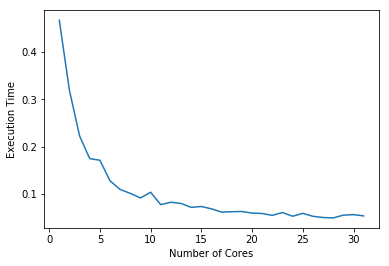

In [5]:
exe_time_vs_cores = get_execution_times(max_num_cores)
plt.plot(range(1, max_num_cores), exe_time_vs_cores)
plt.xlabel('Number of Cores')
plt.ylabel('Execution Time')
plt.show()

### Speedup vs. Number of Cores

In [6]:
speedup_vs_cores = [exe_time_vs_cores[0] / t for t in exe_time_vs_cores]

Curve fit Amdahl's Law to the data:

In [7]:
def amdahls_law(n, s):
    # Speedup = 1 / (s + p/n) where s = 1-p
    return 1 / (s + ((1-s)/n))

popt, pcov = curve_fit(amdahls_law, range(1, max_num_cores), speedup_vs_cores)

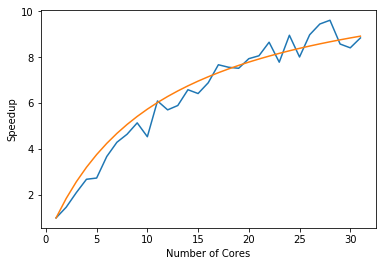

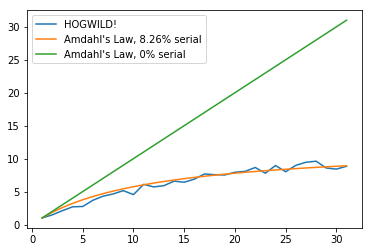

In [8]:
num_cores = range(1, max_num_cores)
plt.plot(num_cores, speedup_vs_cores, label="HOGWILD!")
plt.plot(num_cores, amdahls_law(num_cores, *popt), label="Amdahl's Law, %.2f%% serial" % (100*popt[0]))
plt.xlabel('Number of Cores')
plt.ylabel('Speedup')
plt.show()

plt.plot(num_cores, speedup_vs_cores, label="HOGWILD!")
plt.plot(num_cores, amdahls_law(num_cores, *popt), label="Amdahl's Law, %.2f%% serial" % (100*popt[0]))
plt.plot(num_cores, amdahls_law(num_cores, np.zeros(len(num_cores))), label="Amdahl's Law, 0% serial")
plt.legend()
plt.show()

### L2 Iterate Distance vs. Iterations

In [9]:
def l2_dist(v1, v2):
    assert(len(v1) == len(v2))
    summ = 0.0
    for e1,e2 in zip(v1,v2):
        summ += (e1-e2)**2
    return summ

def get_l2_dists(num_cores):
    # read true iterate
    filename = "%s-%s-%s-iterate.txt" % (data_string, sparsity_string, \
                                                               regressionclassification_string)
    with open(filename) as f:
        length = next(f)
        iter_opt = [float(line) for line in f]
    # read log file
    times = []
    l2_dists = []
    filename = get_dirname() + "/" + "log_%dthreads.csv" % num_cores
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file)
        header = next(csv_reader)
        for row in csv_reader:
            time = row[0]
            iterate = [float(e.strip(' []')) for e in row[1:]]
            times.append(time)
            l2_dists.append(l2_dist(iter_opt, iterate))
    return times, l2_dists

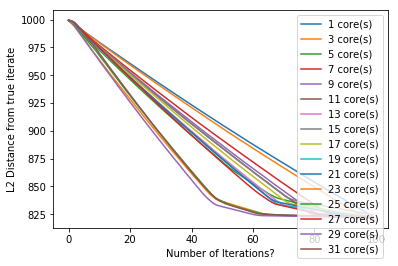

In [10]:
for n in range(1, max_num_cores, 2):
    times, l2_dists = get_l2_dists(n)
    plt.plot(l2_dists, label="%d core(s)" % n)

plt.legend()
plt.xlabel("Number of Iterations?") # TODO
plt.ylabel("L2 Distance from true iterate")
plt.show()